**Data Preparation**

In [1]:
import pandas as pd
df = pd.read_csv('/content/bbcnewsdata.csv', sep='\t')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [3]:
df.tail() #sampel 2225 

,category,filename,title,content
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...
2224,tech,401.txt,Losing yourself in online gaming,"Online role playing games are time-consuming,..."


In [4]:
df.isna().sum()

category    0
filename    0
title       0
content     0
dtype: int64

In [5]:
bbc = df.drop(columns=['filename'])
bbc

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,Be careful how you code,A new European directive could put software w...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...


In [6]:
bbc['article'] = bbc['title'] + " " + bbc['content']
bbc

,category,title,content,article
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly p...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains on Greenspan speech The dollar h...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim The owners ...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,High fuel prices hit BA's profits British Air...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,Pernod takeover talk lifts Domecq Shares in U...
...,...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,BT program to beat dialler scams BT is introd...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,Spam e-mails tempt net shoppers Computer user...
2222,tech,Be careful how you code,A new European directive could put software w...,Be careful how you code A new European direct...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...,US cyber security chief resigns The man makin...


In [7]:
label = pd.get_dummies(bbc.category)
new_label = pd.concat([bbc, label], axis=1)
new_label = new_label.drop(columns='category')
new_label #label/class > 3

,title,content,article,business,entertainment,politics,sport,tech
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly p...,1,0,0,0,0
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains on Greenspan speech The dollar h...,1,0,0,0,0
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim The owners ...,1,0,0,0,0
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,High fuel prices hit BA's profits British Air...,1,0,0,0,0
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,Pernod takeover talk lifts Domecq Shares in U...,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2220,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,BT program to beat dialler scams BT is introd...,0,0,0,0,1
2221,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,Spam e-mails tempt net shoppers Computer user...,0,0,0,0,1
2222,Be careful how you code,A new European directive could put software w...,Be careful how you code A new European direct...,0,0,0,0,1
2223,US cyber security chief resigns,The man making sure US computer networks are ...,US cyber security chief resigns The man makin...,0,0,0,0,1


In [8]:
bbcnews = new_label['article'].values
label = new_label[['business', 'entertainment', 'politics', 'sport', 'tech']].values

**Modeling**

In [9]:
#Validation set 20%
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bbcnews, label, test_size=0.2, shuffle=True)

In [10]:
#Implementasi Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(x_train) 
 
sekuens_train = tokenizer.texts_to_sequences(x_train)
sekuens_test = tokenizer.texts_to_sequences(x_test)
 
padded_train = pad_sequences(sekuens_train, maxlen=200, truncating="post") 
padded_test = pad_sequences(sekuens_test, maxlen=200, truncating="post")

In [11]:
#Implementasi LSTM, Sequential, Embedding, 
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64, input_length=200),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [12]:
#Implementasi Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.91 and logs.get('val_accuracy')>0.91):
      self.model.stop_training = True
      print("\nTraining dihentikan, target akurasi pada training set dan validation set telah mencapai lebih dari 90%")
callbacks = myCallback()

In [13]:
num_epochs = 30
history = model.fit(padded_train, y_train, epochs=num_epochs, 
                    validation_data=(padded_test, y_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
56/56 - 16s - loss: 1.5765 - accuracy: 0.2640 - val_loss: 1.2858 - val_accuracy: 0.4742
Epoch 2/30
56/56 - 13s - loss: 1.3264 - accuracy: 0.4551 - val_loss: 1.1029 - val_accuracy: 0.5124
Epoch 3/30
56/56 - 13s - loss: 0.9011 - accuracy: 0.6163 - val_loss: 0.9834 - val_accuracy: 0.5416
Epoch 4/30
56/56 - 13s - loss: 0.4089 - accuracy: 0.8730 - val_loss: 0.8929 - val_accuracy: 0.6584
Epoch 5/30
56/56 - 13s - loss: 0.3552 - accuracy: 0.9034 - val_loss: 0.3990 - val_accuracy: 0.8831
Epoch 6/30
56/56 - 13s - loss: 0.1054 - accuracy: 0.9764 - val_loss: 0.3460 - val_accuracy: 0.9011
Epoch 7/30
56/56 - 13s - loss: 0.0761 - accuracy: 0.9843 - val_loss: 0.4999 - val_accuracy: 0.8382
Epoch 8/30
56/56 - 13s - loss: 0.0104 - accuracy: 0.9989 - val_loss: 0.3912 - val_accuracy: 0.8989
Epoch 9/30
56/56 - 13s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.3726 - val_accuracy: 0.9079
Epoch 10/30
56/56 - 13s - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.8022 - val_accuracy: 0.8494
Epoch 11/

**Evaluation**


In [14]:
import matplotlib.pyplot as plt

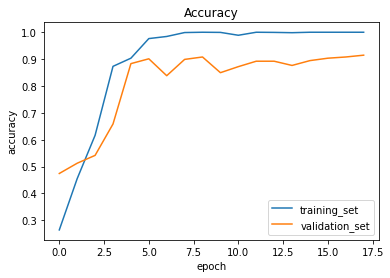

In [15]:
#Plot Akurasi
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'], label='training_set')
plt.plot(history.history['val_accuracy'], label='validation_set')
plt.legend()

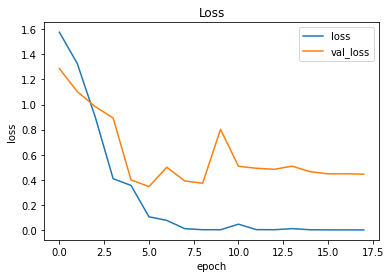

In [16]:
#Plot Loss
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()